<h1> PERCEPTION IS ALL YOU NEED!!!!</h1>
<h3> The notebook is the implementation of image colorisation using UNet and a combined 'pixel to pixel(MSE)' and perceptual loss using VGG19. </h3>
<h4><b>Caution</b> : This is not the final result, its only trained on 20 epochs with batch normalization and skip-connection and is just about the process. I would be working on another version soon when i have time to spend 15 hours watching it train 😅. </h4>

<h3>Import libraries<h3>

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2
import torch
import os
import glob
from albumentations import (
    Compose, HorizontalFlip, RandomRotate90, RandomBrightnessContrast, Resize
)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm

<h3>Installing the dataset.</h3>

In [1]:
! wget http://images.cocodataset.org/zips/test2014.zip

--2024-06-13 06:58:12--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.202.17, 16.182.36.217, 54.231.200.241, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.202.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: 'test2014.zip'

test2014.zip        100%[===================>]   6.20G  34.8MB/s    in 2m 52s  

2024-06-13 07:01:04 (36.9 MB/s) - 'test2014.zip' saved [6660437059/6660437059]



In [ ]:
! unzip test2014.zip

<h3> Check the device availibility. </h3>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<h3>Visualising some images. </h3>


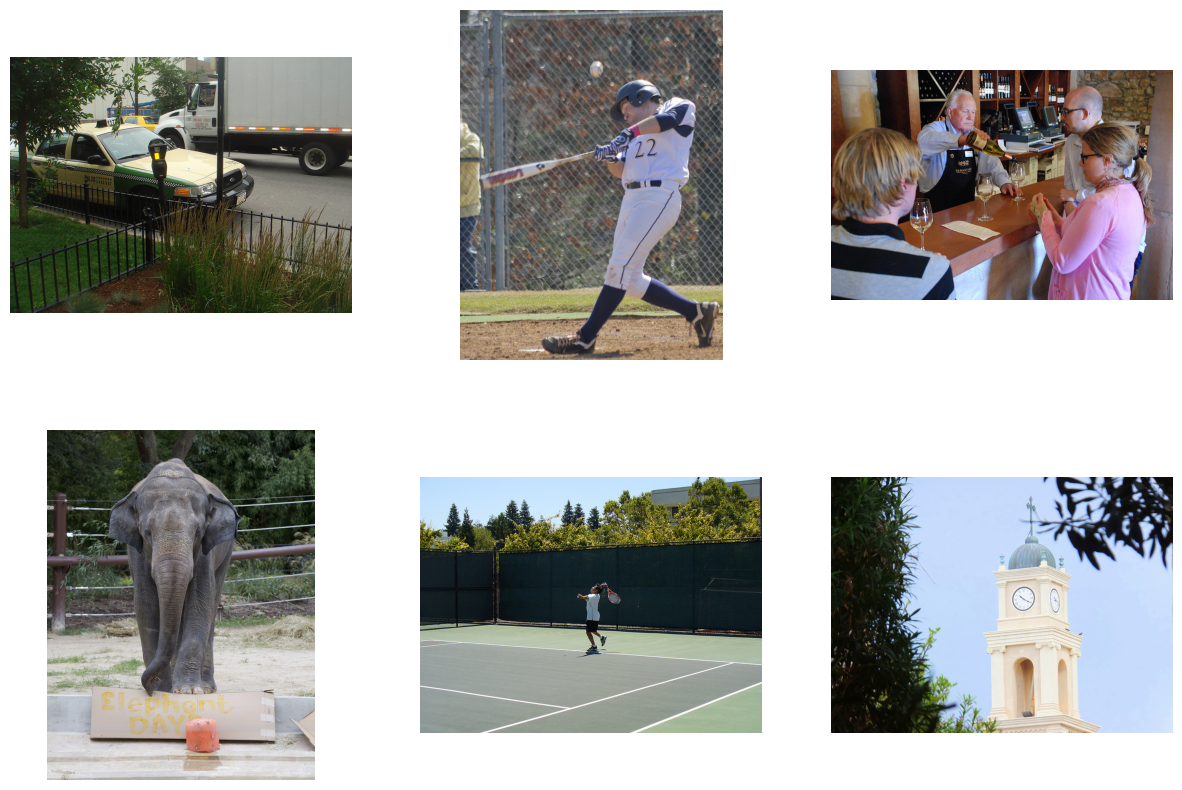

In [8]:
image_paths = ['/kaggle/working/test2014/COCO_test2014_000000000001.jpg','/kaggle/working/test2014/COCO_test2014_000000000016.jpg',
               '/kaggle/working/test2014/COCO_test2014_000000000069.jpg','/kaggle/working/test2014/COCO_test2014_000000000128.jpg',
               '/kaggle/working/test2014/COCO_test2014_000000000219.jpg','/kaggle/working/test2014/COCO_test2014_000000000276.jpg']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, image_path in zip(axes, image_paths):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

<br><h3>Data Preprocessing</h3>
<br>
1.   Defineing the custom dataset class. <br>
2.   Resize all images to 128*128. <br>
3.   Convert RGB to LAB and then spliting L and AB channels.



In [9]:
class LABColorizationDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(image)
        L = L / 255.0
        A = (A / 128.0) - 1.0
        B = (B / 128.0) - 1.0

        L = np.stack([L], axis=-1).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=L)
            L = augmented['image']

        target_size = (L.shape[0], L.shape[1])
        A = cv2.resize(A, target_size, interpolation=cv2.INTER_LINEAR)
        B = cv2.resize(B, target_size, interpolation=cv2.INTER_LINEAR)

        L = torch.tensor(L).permute(2, 0, 1).float()
        A = torch.tensor(A).unsqueeze(0).float()
        B = torch.tensor(B).unsqueeze(0).float()

        return L.to(device), torch.cat((A, B), dim=0).to(device)


In [10]:
def get_transform(target_size=(128, 128)):
    return Compose([
        Resize(target_size[0], target_size[1])
    ])

In [12]:
print(f"Found {len(image_paths)} images.")
if len(image_paths) == 0:
    print("No images found. Please check the image directory path and file extensions.")

Found 40775 images.


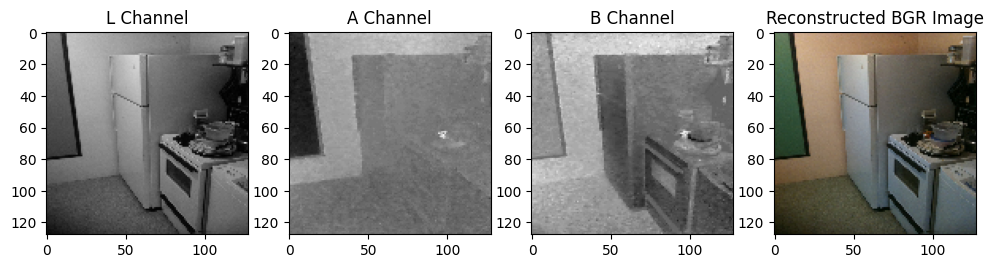

In [14]:
for batch_idx, (L_batch, AB_batch) in enumerate(dataloader):
    

    if batch_idx == 0:
        L_sample = L_batch[0].cpu().numpy().transpose(1, 2, 0).squeeze()
        AB_sample = AB_batch[0].cpu().numpy()
        A_sample = AB_sample[0, :, :]
        B_sample = AB_sample[1, :, :]

        L_sample_vis = (L_sample * 255).astype(np.uint8)
        A_sample_vis = ((A_sample + 1.0) * 128).astype(np.uint8)
        B_sample_vis = ((B_sample + 1.0) * 128).astype(np.uint8)

        LAB_sample_vis = cv2.merge([L_sample_vis, A_sample_vis, B_sample_vis])
        BGR_sample_vis = cv2.cvtColor(LAB_sample_vis, cv2.COLOR_LAB2BGR)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.title('L Channel')
        plt.imshow(L_sample, cmap='gray')

        plt.subplot(1, 4, 2)
        plt.title('A Channel')
        plt.imshow(A_sample, cmap='gray')

        plt.subplot(1, 4, 3)
        plt.title('B Channel')
        plt.imshow(B_sample, cmap='gray')

        plt.subplot(1, 4, 4)
        plt.title('Reconstructed BGR Image')
        plt.imshow(cv2.cvtColor(BGR_sample_vis, cv2.COLOR_BGR2RGB))

        plt.show()

    if batch_idx >= 2:
        break

In [24]:
image_directory = '/kaggle/working/test2014'
image_paths = glob.glob(os.path.join(image_directory, '*.jpg'))
dataset = LABColorizationDataset(image_paths, transform=get_transform())
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

<h3> Model Defination </h3>

In [17]:
class Unet(nn.Module):
  def __init__(self):
    super(Unet,self).__init__()

    self.downsample = nn.Sequential(

        nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

    )

    self.upsample = nn.Sequential(

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(256, 128, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope=0.01, inplace= True),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.LeakyReLU(negative_slope = 0.01, inplace = True),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(64, 2, kernel_size = 3, padding = 1),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Tanh()

    )

  def forward(self,x):
    ds = self.downsample(x)
    output = self.upsample(ds)

    return output

<h3>Perceptual Loss</h3>

In [18]:
class PerceptualLoss(nn.Module):
  def __init__(self):
    super(PerceptualLoss ,self).__init__()
    vgg19 = models.vgg19(pretrained=True).features[:36].eval()
    for param in vgg19.parameters():
      param.requires_grad = False
    self.vgg19 = vgg19
    self.criterion = nn.MSELoss()

  def forward(self, output, target):
    output_fea = self.vgg19(output)
    target_fea = self.vgg19(target)

    return self.criterion(output_fea , target_fea)

<h3> Initializing model parameters </h3>

In [19]:
percep_loss = PerceptualLoss().to(device)
color_net = Unet().to(device)
optimizer = optim.Adam(color_net.parameters(), lr=1e-3)
num_epochs = 20

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 163MB/s]  


In [26]:
epoch_m = []
loss_m = []

<h3> Model Training </h3>

In [27]:
writer = SummaryWriter('runs/colorization')
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for i, (L,AB) in tqdm(enumerate(dataloader)):
    L, AB = L.to(device), AB.to(device)
    optimizer.zero_grad()

    output_AB = color_net(L)
    pixel_loss = nn.MSELoss()(output_AB,AB)

    output_LAB = torch.cat([L , output_AB], dim = 1)
    target_LAB = torch.cat([L , AB], dim = 1)

    p_loss = percep_loss(output_LAB, target_LAB)
    loss = pixel_loss + 0.1 * p_loss
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  avg_epoch_loss = epoch_loss/len(dataloader)
  
  
  epoch_m.append(epoch+1)
  loss_m.append(avg_epoch_loss)


  writer.add_scalar('LOSS/EPOCH', avg_epoch_loss, epoch)

  print(f"Epoch {epoch+1} , Loss:{avg_epoch_loss}")

torch.save(color_net.state_dict() , 'unet_ploss_vgg19.pth')
writer.close()

319it [08:02,  1.51s/it]


Epoch 1 , Loss:0.01832824651747475


319it [08:01,  1.51s/it]


Epoch 2 , Loss:0.017771693258940426


319it [08:01,  1.51s/it]


Epoch 3 , Loss:0.017462976148416257


319it [07:58,  1.50s/it]


Epoch 4 , Loss:0.017353961851482854


319it [07:56,  1.50s/it]


Epoch 5 , Loss:0.017142105602358577


319it [07:58,  1.50s/it]


Epoch 6 , Loss:0.0169866741269967


319it [07:56,  1.49s/it]


Epoch 7 , Loss:0.016790795297621747


319it [07:57,  1.50s/it]


Epoch 8 , Loss:0.01661654196235827


319it [08:00,  1.51s/it]


Epoch 9 , Loss:0.016344207084991715


319it [07:56,  1.50s/it]


Epoch 10 , Loss:0.016098403649223634


319it [07:59,  1.50s/it]


Epoch 11 , Loss:0.01571256281416805


319it [08:02,  1.51s/it]


Epoch 12 , Loss:0.015371369492834824


319it [08:01,  1.51s/it]


Epoch 13 , Loss:0.01500193003074596


319it [08:06,  1.52s/it]


Epoch 14 , Loss:0.014680249777076573


319it [08:04,  1.52s/it]


Epoch 15 , Loss:0.014377541335001822


319it [08:04,  1.52s/it]


Epoch 16 , Loss:0.014132801659381876


319it [08:04,  1.52s/it]


Epoch 17 , Loss:0.013885861230564529


319it [08:01,  1.51s/it]


Epoch 18 , Loss:0.013647910660033503


319it [08:02,  1.51s/it]


Epoch 19 , Loss:0.013435980380982815


319it [08:01,  1.51s/it]

Epoch 20 , Loss:0.013272970401007554


<h3>Loss Curve</h3>

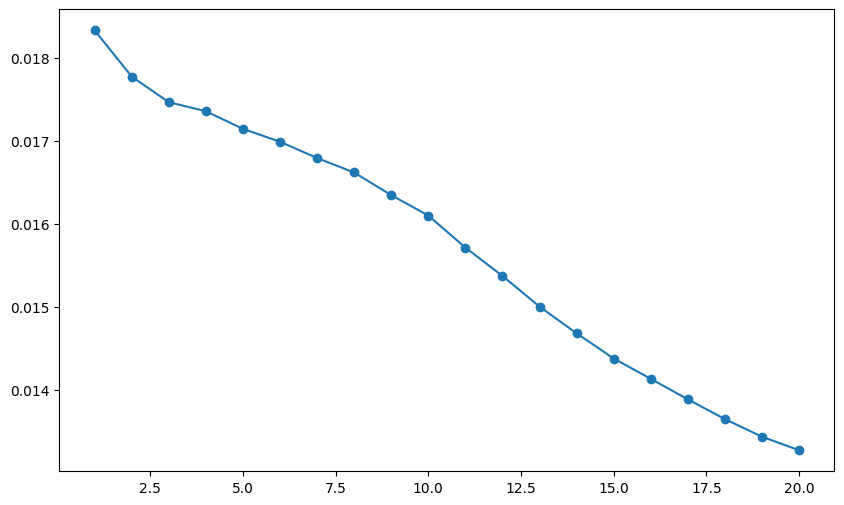

In [70]:
plt.figure(figsize=(10,6))
plt.plot(epoch_m,loss_m,label='Loss',marker='o',linestyle='-')
plt.show()

<h3> Visualizing random images from training dataset. </h3>

In [28]:
def visualize(image_pth, model):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (128,128), interpolation=cv2.INTER_LINEAR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

  L, A, B = cv2.split(image)
  L_norm = L / 255.0
  AB_pred = model(L_norm)
  A_pred, B_pred = cv2.split(AB_pred)
  A_pred = ((A_pred + 1.0) * 128).astype(np.uint8)
  B_pred = ((B_pred + 1.0) * 128).astype(np.uint8)

  image_pred = cv2.cvtColor(torch.cat([L, A_pred, B_pred],dim = 1), cv2.COLOR_LAB2BGR)
  image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)



  plt.figure(figsize=(12, 4))

  plt.subplot(1, 4, 1)
  plt.title('L Channel')
  plt.imshow(L, cmap='gray')

  plt.subplot(1, 4, 2)
  plt.title('Predicted')
  plt.imshow(image_pred, cmap='gray')

  plt.subplot(1, 4, 3)
  plt.title('Ground Truth')
  plt.imshow(image, cmap='gray')

  plt.show()



<h3> Loading model </h3>

In [53]:
model = Unet()
model_path = '/kaggle/working/unet_ploss_vgg19.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

Unet(
  (downsample): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slo

<h3> Defining functions for visualizing the images </h3>

In [66]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel = image_lab[:,:,0]
    l_channel_normalized = l_channel / 255.0
    return l_channel_normalized, image_lab

def scale_ab_channels(ab_channels):
    return (ab_channels * 128) - 128

def combine_channels(l_channel, ab_channels):
    l_channel = np.expand_dims(l_channel, axis=-1) * 255.0 
    lab_image = np.concatenate((l_channel, ab_channels), axis=-1)
    return lab_image

def display_images(original, predicted, ground_truth):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original (L)')
    axs[0].axis('off')
    axs[1].imshow(predicted)
    axs[1].set_title('Predicted')
    axs[1].axis('off')
    axs[2].imshow(ground_truth)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    plt.show()

<h3> Randomly selecting 10 images from dataset and then visualizing them. </h3>

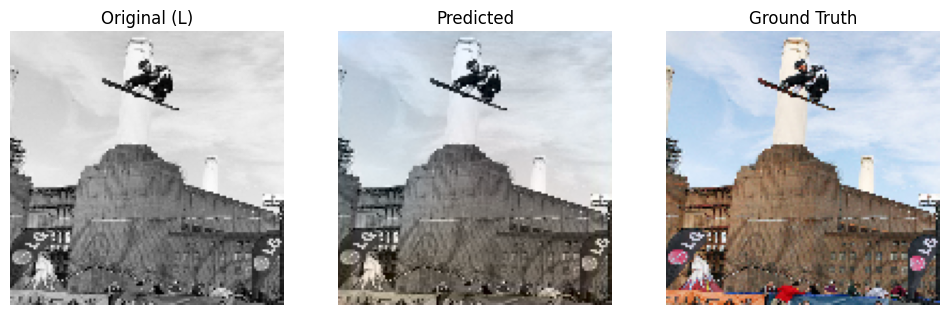

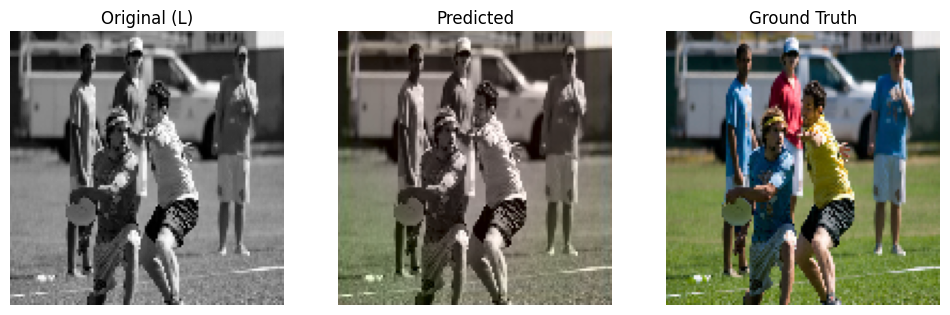

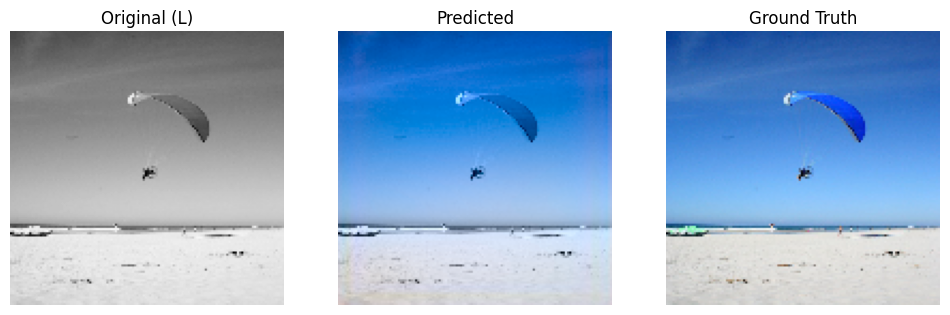

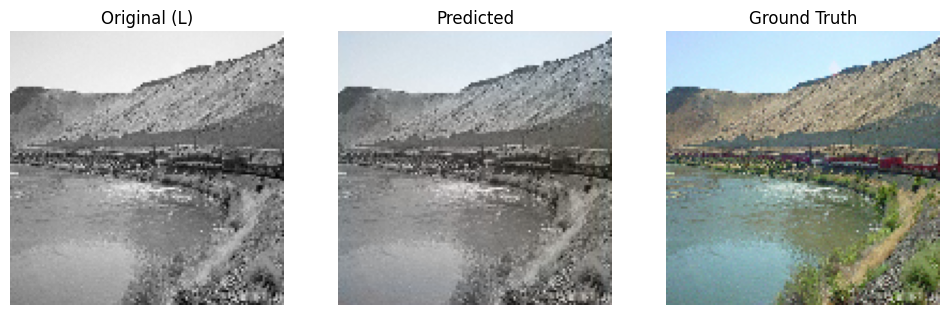

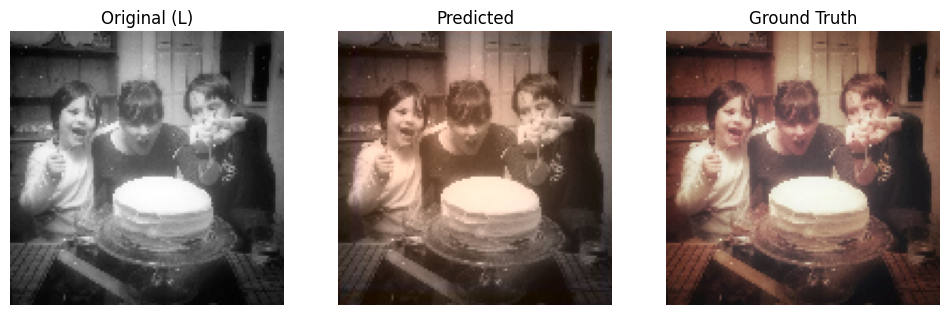

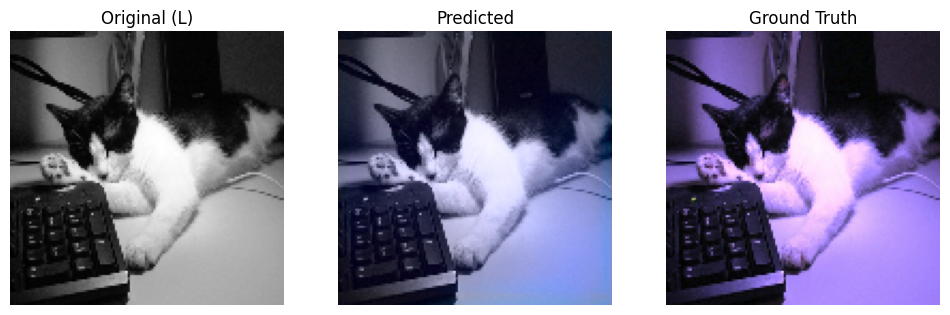

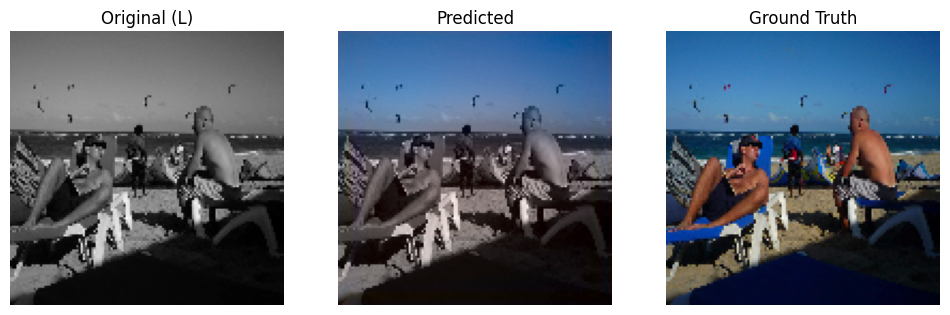

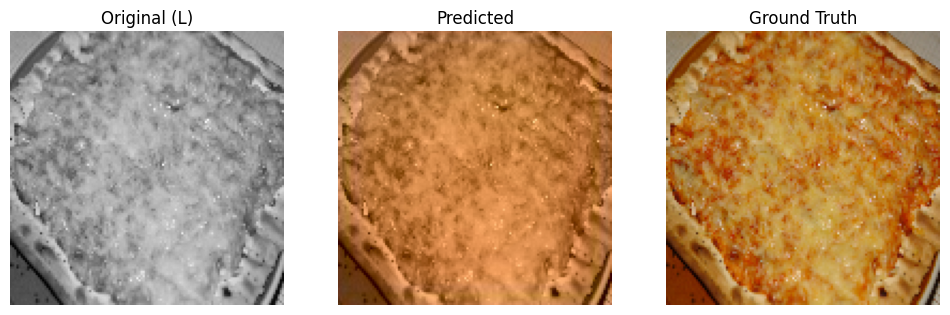

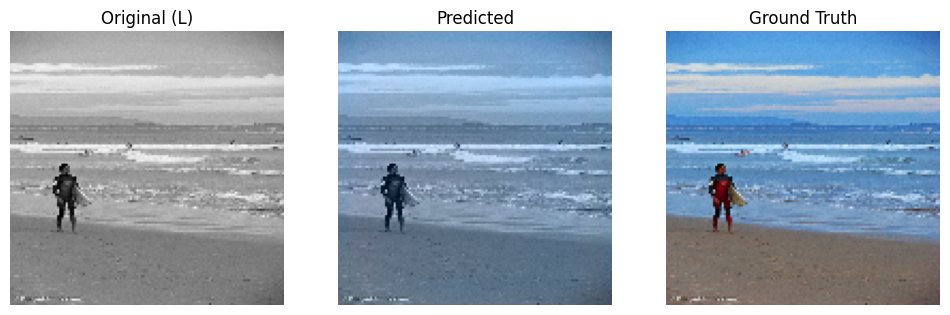

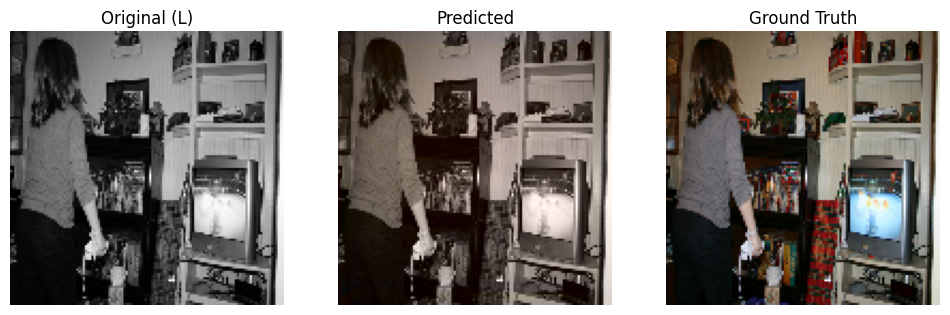

In [65]:
def sample_image_paths(directory, sample_size=10):
    all_files = os.listdir(directory)
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = [file for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]
    
    sampled_files = random.sample(image_files, sample_size)
    
    sampled_paths = [os.path.join(directory, file) for file in sampled_files]
    
    return sampled_paths


directory_path = '/kaggle/working/test2014'
sampled_image_paths = sample_image_paths(directory_path)


for image_path in sampled_image_paths:
  l_channel, image_lab = preprocess_image(image_path)

  l_channel_input = np.expand_dims(l_channel, axis=0)
  l_channel_input = np.expand_dims(l_channel_input, axis=1)  # Correcting the channel position for PyTorch
  l_channel_tensor = torch.from_numpy(l_channel_input).float().to(device)

  with torch.no_grad():
      predicted_ab_channels = model(l_channel_tensor).squeeze(0).cpu().numpy()

  predicted_ab_channels = predicted_ab_channels.transpose(1, 2, 0)  # Transpose to (height, width, 2)
  scaled_ab_channels = scale_ab_channels(predicted_ab_channels)

  predicted_image_lab = combine_channels(l_channel, scaled_ab_channels)

  predicted_image_rgb = cv2.cvtColor(predicted_image_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

  ground_truth_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)

  display_images(image_lab[:,:,0], predicted_image_rgb, ground_truth_rgb)


<h3> For visualizing a single image. </h3>

In [59]:
def visualize(image_path,model):
  l_channel, image_lab = preprocess_image(image_path)

  l_channel_input = np.expand_dims(l_channel, axis=0)
  l_channel_input = np.expand_dims(l_channel_input, axis=1)  # Correcting the channel position for PyTorch
  l_channel_tensor = torch.from_numpy(l_channel_input).float().to(device)

  with torch.no_grad():
      predicted_ab_channels = model(l_channel_tensor).squeeze(0).cpu().numpy()

  predicted_ab_channels = predicted_ab_channels.transpose(1, 2, 0)  # Transpose to (height, width, 2)
  scaled_ab_channels = scale_ab_channels(predicted_ab_channels)

  predicted_image_lab = combine_channels(l_channel, scaled_ab_channels)

  predicted_image_rgb = cv2.cvtColor(predicted_image_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

  ground_truth_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)

  display_images(image_lab[:,:,0], predicted_image_rgb, ground_truth_rgb)

Enter your image path /kaggle/working/test2014/COCO_test2014_000000000001.jpg


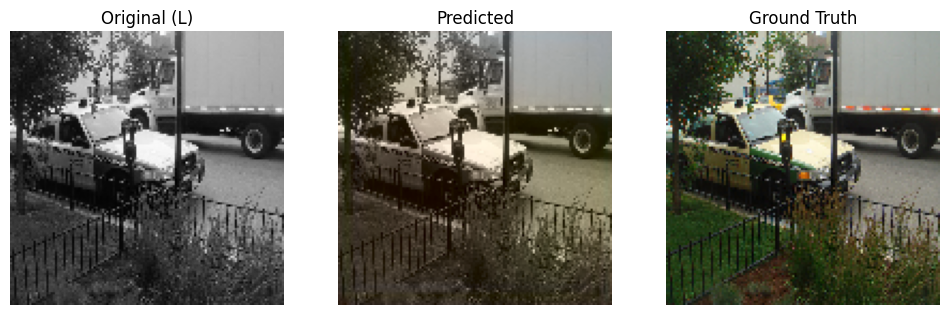

In [63]:
img_pathi = input("Enter your image path")
visualize(img_pathi,model)